# Uni-Variate Air Pollution Forecasting 

# Objective: 
- This is a one variable time series forecasting work 
- Uni-variate foreasting will be compared to multi-variate forecasting (from another notebook) using LSTM model.

# About the Data:
- The datset used here is the airpolution dataset of Beijing city of China. 
- Data is collected from the following website: https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
- The feature list in the raw data is explained as follow:

    * No: number of rows
    * year: year of data in every row
    * month: month of data in every row
    * day: day of data in every row
    * hour: hour of data in every row
    * pm2.5: PM2.5 refers to particulate matter with a diameter of 2.5 micrometers or smaller. These fine particles are a significant component of air pollution and can have serious health effects due to their ability to penetrate deep into the lungs and enter the bloodstream.
    * DEWP: The dew point is the temperature at which air becomes saturated with moisture and water vapor begins to condense into liquid water. It is a critical parameter in understanding and predicting weather
    * TEMP: Temperature
    * PRES: Pressure
    * cbwd: Combined wind direction
    * Iws: Cumulated wind speed
    * Is: Cumulated hours of snow
    * Ir: Cumulated hours of rain



# General Forecasting Process of LSTM Models:
* Before machine learning can be used, time series forecasting problems must be re-framed as supervised learning problems. From a sequence to pairs of input and output sequences. 
* After preparing data, data is split into train and test 
* Train data is used for training the model
* Test data is used for forecasting
* In this notebook, one time lag (time_lag=1), 8 features (or variables), and one prediction (of pollution)

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Data preperation and preprocessing

In [2]:
df = pd.read_csv('Book1.csv')
df.head()

,"No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir"
0,"1,2010,1,1,0,NA,-21,-11,1021,NW,1.79,0,0"
1,"2,2010,1,1,1,NA,-21,-12,1020,NW,4.92,0,0"
2,"3,2010,1,1,2,NA,-21,-11,1019,NW,6.71,0,0"
3,"4,2010,1,1,3,NA,-21,-14,1019,NW,9.84,0,0"
4,"5,2010,1,1,4,NA,-20,-12,1018,NW,12.97,0,0"


In [3]:
# We replaced the names with string and separate them and determine the new columns to our df
df[['No','Year', 'Month', 'Day', 'Hour', 'pollution', 'dew point', 'temperature', 'pressure', 'wind direction', 'wind speed', 'snow', 'rain']] = df['No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir'].str.split(',', expand=True)

# Drop previous columns and column "No"
df.drop(columns=['No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir'], inplace=True)
df.drop(columns=['No'], inplace=True)

# We have a copy of our df in data"
data_main = df.copy()

In [4]:
# Let's convert the date-time information into a single date-time so that we can use it as an index in Pandas
def combine_datetime(df):
    year = str(df['Year'])
    month = str(df['Month'])
    day = str(df['Day'])
    hour = str(df['Hour'])
    combined_string = year + '-' + month + '-' + day + ' ' + hour
    return datetime.strptime(combined_string, '%Y-%m-%d %H')


df['Date'] = df.apply(combine_datetime, axis=1)
df.drop(columns=['Year', 'Month', 'Day', 'Hour'], axis=1)
df = df[['Date', 'pollution']]

# Set 'Date' column as indx for df
df.set_index('Date', inplace = True) 

# Let's see the NA values for "pollution" column
df[df['pollution'] == 'NA']

# Replace "NA" values with 0
df.iloc[:, 0].replace('NA', 0)

# first 24 hours of df is dropped
df = df[24 :]

# Save the df in file named:pollution.csv
df.to_csv('pollution.csv')

# Read 'pollution.csv'
df = pd.read_csv('pollution.csv')

# Set 'Date' as index for df
df = df.set_index('Date')

df.head()

,pollution
Date,
2010-01-02 00:00:00,129.0
2010-01-02 01:00:00,148.0
2010-01-02 02:00:00,159.0
2010-01-02 03:00:00,181.0
2010-01-02 04:00:00,138.0


## Missing Values

In [5]:
#On the pollution column of our data, impute the missing values with the Observation Carried Forward (LOCF) 
df['pollution']= df['pollution'].fillna(method ='bfill')

In [6]:
nul_data = pd.isnull(df['pollution']) 
sum(nul_data)

0

# Plotting the Data

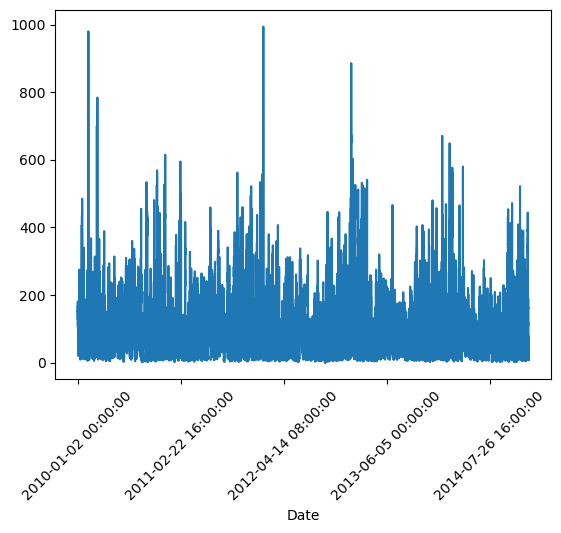

In [7]:
df["pollution"].plot()
plt.xticks(rotation = 45)
plt.show()

# Long Short Term Model (LSTM)¶

- Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) that are well-suited to time series forecasting due to their ability to learn long-term dependencies. LSTMs are particularly effective for datasets where the temporal order and lag relationships are critical, such as in weather forecasting, stock prices, and many other sequential data problems.
- Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) model developed due to the vanishing gradient problem in traditional RNNs. LSTM method is used to capture long term dependencies and non-linear patterns in the data. LSTM models are trained according to backpropagation through time which reduces the vanishing gradient problem to optimize the network parameters.
- LSTM networks contain memory cells that allow them to retain information over time. Each LSTM cell has 3 gates as forget gate, input gate and output gate. Through forget gate, it will forget unimportant information since it determines which information is considered as important information. In the input gate new information will be added to the LSTM cell. The output gate also provides us with the final prediction of model. LSTM can be successfully directed for multivariate time series forecasting. Due to its liability to retain the information over long sequence of data, it is of most importance for larger and more complex data.

# Data Preparation for LSTM model
- Before machine learning can be used, time series forecasting problems must be re-framed as supervised learning problems and input values must be normalized.  
- We want to predict the pollution for the current time.
- wind direction column is categorical and should be encoded to numeric values.
- Data is loaded and is normalized using MinMaxScaler
- All values are made sure to be 'float' type
- "lstm_data_preparation" function is used to frame the final data
- Unneeded columns that we are not going to forecast them are dropped from a final dataframe. 
- We are going to have 8 variables or features () and forecst the air pollution "pollution" as an output.
- lag of time of 1 is investigated first and we are going to look back for only 1 time to do the forecasting first. 
- An algorithm is developed to learn how to predict the output patterns from the input patterns.

In [8]:
#Load the dataset
df.to_csv('pollution.csv')
df = pd.read_csv('pollution.csv', header=0, index_col=0)
df

,pollution
Date,
2010-01-02 00:00:00,129.0
2010-01-02 01:00:00,148.0
2010-01-02 02:00:00,159.0
2010-01-02 03:00:00,181.0
2010-01-02 04:00:00,138.0
...,...
2014-12-31 19:00:00,8.0
2014-12-31 20:00:00,10.0
2014-12-31 21:00:00,10.0


In [9]:
df_lstm = df['pollution']

In [10]:
def prepare_data(df, step):
    df_as_numpy = df.to_numpy()
    x=[]
    y=[]
    for i in range(len(df_as_numpy)-step):
        rows = [[a] for a in df_as_numpy[i:i+step]]
        x.append(rows)
        label = df_as_numpy[i+step]
        y.append(label)
    return np.array(x), np.array(y)

In [11]:
x1, y1 = prepare_data(df_lstm, 2)

In [12]:
def train_test_data(x, y, df):
    train = int(len(x)*0.8)
    test = int(len(x))

    x_train, y_train = x[:train], y[:train]
    x_test, y_test = x[train:test], y[train:test]

    dates_train = df[0:train]
    dates_test = df[train:test]
    
    return x_train, y_train, x_test, y_test

In [13]:
x_train1, y_train1, x_test1, y_test1 = train_test_data(x1, y1, df_lstm)

In [14]:
x_train1.shape, y_train1.shape, x_test1.shape, y_test1.shape

((35038, 2, 1), (35038,), (8760, 2, 1), (8760,))

In [15]:
def plot_train_test(x, df):
    a = int(len(x)*0.8)
    b = int(len(x))
    df_lstm_train = df[0:a]
    df_lstm_test = df[a:b]
    plt.plot(df_lstm_train)
    plt.plot(df_lstm_test) 
    plt.legend(['Train Data', 'Test Data'])
    plt.show()


In [ ]:
plot_train_test(x1, df_lstm)

In [16]:
def model_LSTM(x_train, y_train):
    model = Sequential()
    model.add(LSTM(units = 100, activation='relu', input_shape=(2,1)))
    model.add(Dense(1)) 
    model.compile(loss='mse',
                   optimizer='adam')
    model.fit(x_train, y_train, epochs=25)
    return model

In [17]:
model_lstm = model_LSTM(x_train1, y_train1)



Epoch 1/25

1095/1095 [==============================] - 3s 1ms/step - loss: 915.8560
Epoch 2/25
1095/1095 [==============================] - 2s 1ms/step - loss: 577.3760
Epoch 3/25
1095/1095 [==============================] - 2s 1ms/step - loss: 577.9679
Epoch 4/25
1095/1095 [==============================] - 2s 1ms/step - loss: 580.0403
Epoch 5/25
1095/1095 [==============================] - 2s 1ms/step - loss: 568.0326
Epoch 6/25
1095/1095 [==============================] - 2s 1ms/step - loss: 562.4173
Epoch 7/25
1095/1095 [==============================] - 2s 1ms/step - loss: 561.0901
Epoch 8/25
1095/1095 [==============================] - 2s 1ms/step - loss: 566.9026
Epoch 9/25
1095/1095 [==============================] - 2s 1ms/step - loss: 560.6887
Epoch 10/25
1095/1095 [==============================] - 2s 1ms/step - loss: 560.6308
Epoch 11/25
1095/1095 [==============================] - 2s 1ms/step - loss: 559.2733
Epoch 12/25
1095/1095 [==============================] - 2s 

In [18]:
def prepare_data(df, step):
    df_as_numpy = df.to_numpy()
    x=[]
    y=[]
    for i in range(len(df_as_numpy)-step):
        rows = [[a] for a in df_as_numpy[i:i+step]]
        x.append(rows)
        label = df_as_numpy[i+step]
        y.append(label)
    return np.array(x), np.array(y)

In [21]:
a = int(len(x1)*0.8)
b = int(len(x1))
df_lstm_train = df_lstm[0:a]
df_lstm_test = df_lstm[a:b]

In [22]:
def plot_test_prediction(model, x, y, df):
    test_predictions = model.predict(x).flatten()
    
    plt.plot(df_lstm_train)
    plt.plot(df_lstm_test.index, test_predictions)
    plt.plot(df_lstm_test.index, df_lstm_test)
    plt.legend(['Train', 'Test Predictions_LSTM', 'Open'])
    plt.xticks(rotation = 25)
    
    mse = mean_squared_error(y, test_predictions)
    mae = mean_absolute_error(y, test_predictions)
    mape = mean_absolute_percentage_error(y, test_predictions)
    return mse, mae, mape

In [ ]:
plot_test_prediction(model_lstm, x_test1, y_test1, df_lstm)

274/274 [==============================] - 0s 919us/step


(441.19352317219614, 11.498121798746118, 0.19866070070242864)

In [ ]:
def plot_train_test_prediction(model, df_lstm_train, df_lstm_test, x, ytrain, ytest):
    test_predictions = model.predict(x).flatten()
    plt.plot(df_lstm_train.index, ytrain)
    plt.plot(df_lstm_test.index, test_predictions)
    plt.plot(df_lstm_test.index, ytest)
    plt.legend(['Open rain', 'Test Predictions_LSTM', 'Open Test'])

In [ ]:
plot_train_test_prediction(model_lstm, df_lstm_train, df_lstm_test, x_test1, y_train1, y_test1)